In [29]:
import pandas as pd
import os
import scipy.ndimage as nd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
from keras.models import load_model
sys.path.append('./SRC')
from batch_renorm import BatchRenormalization
import random
import glob
import nibabel as nib
from collections import defaultdict
from Util import plotData,getPredictions

In [30]:
path = '../Data/CAT_UK_Biobank/'
paths = glob.glob(path+'*/mri/mwp2*.nii')

In [31]:
len(paths)

21387

In [4]:
idToPath = defaultdict(list)
for i in paths:
    idToPath[i.split('/')[3][:7]] = idToPath[i.split('/')[3][:7]]+[i]

def loadHeader(ID,idToPath=idToPath):
    header = nib.load(idToPath[ID][0]).header
    return header

def loadMR(path):
    img = nib.load(path).get_data()
    return img

In [5]:
ids = list(idToPath.keys())

In [22]:
idFrame = pd.DataFrame.from_dict(idToPath,orient='index')
idFrame['ID'] = idFrame.index.astype(int)

In [23]:
subjectInfoPath = '../Data/ID_Gender_YOB_MOB.txt'
ageInfo = pd.read_csv('../Data/UK_Biobank_ImagingVisitAge2.txt',delim_whitespace=True)
ageInfo.columns = ['ID','Age']
subjectInfo = pd.read_csv(subjectInfoPath,delim_whitespace=True)
subjectInfo = subjectInfo.drop(subjectInfo.index[0])
subjectInfo.columns = ['ID','gender','YOB','month']
subjectInfo = pd.merge(subjectInfo,ageInfo,how='inner',on='ID')
tmp = pd.read_csv('../Data/ukb2489_id2pn.txt',header=None,sep='\t')
tmp.columns  = ['ID','PN']
subjectInfo = pd.merge(tmp,subjectInfo,on='ID',how='inner')
data = pd.merge(subjectInfo,idFrame,how='inner',on=['ID','ID'])
data['scanner'] = np.zeros(data.shape[0])
data['gender'] = 1 - data['gender']

In [24]:
X = data[[0,'gender','scanner']].values
y = data['Age'].values

In [9]:
dataShape = (121,145,121)

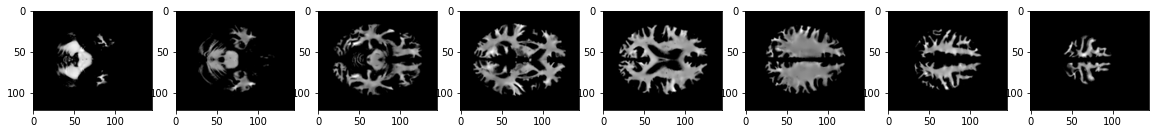

In [13]:
plotData(X,subjectNr=0,augment=False,resize=False,c=2,d=10,nSlices=8)

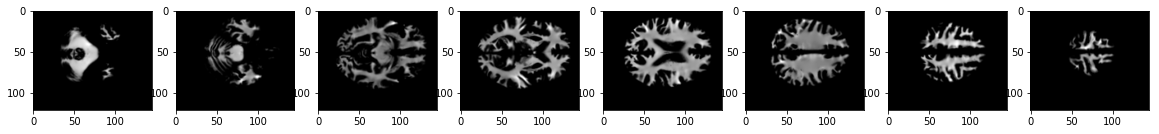

In [15]:
plotData(X,subjectNr=0,augment=True,resize=False,c=2,d=10,nSlices=8)

Fist let's try the model only trained on the Icelandic data

In [17]:
model = load_model('../Models/BrainAgeResNet(WM)(Ice)')

0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000
4250
4500
4750
5000
5250
5500
5750
6000
6250
6500
6750
7000
7250
7500
7750
8000
8250
8500
8750
9000
9250
9500
9750
10000
10250
10500
10750
11000
11250
11500
11750
12000
12250
('Validation R^2: ', -1.0372404698266608)
('Validation MAE: ', 9.226505946792658)


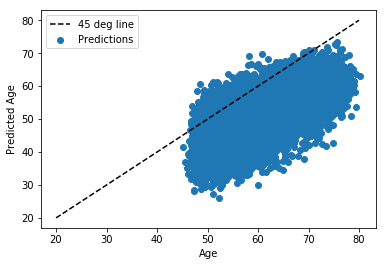

In [18]:
n = X.shape[0]
predictions = getPredictions(model,X[:n,:],batchSize=1)
print('Validation R^2: ',r2_score(y[:n],predictions))
print('Validation MAE: ',mean_absolute_error(y[:n],predictions))
plt.scatter(y[:n],predictions,label='Predictions')
y_range = np.arange(20,np.max(y[:n]))
plt.plot(y_range,y_range,c='black',ls='dashed',label='45 deg line')
plt.xlabel('Age')
plt.ylabel('Predicted Age')
plt.legend()
plt.show()

In [19]:
brainAge = pd.DataFrame({'Asc':data['ID'].values,'PredictedBrainAge':np.array(predictions)},index = data['ID'])
brainAge.to_csv('../Results/WM_CNN_NoTL_pred.txt',sep='\t')

Now let's try the model trained on the Icelandic data and IXI.

In [20]:
model = load_model('../Models/BrainAgeResNet(WM)(IceAndIXI))

0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000
4250
4500
4750
5000
5250
5500
5750
6000
6250
6500
6750
7000
7250
7500
7750
8000
8250
8500
8750
9000
9250
9500
9750
10000
10250
10500
10750
11000
11250
11500
11750
12000
12250
('Validation R^2: ', 0.34506930320744134)
('Validation MAE: ', 4.830228107383762)


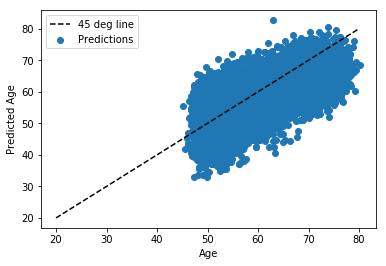

In [21]:
n = X.shape[0]
predictions = getPredictions(model,X[:n,:],batchSize=1)
print('Validation R^2: ',r2_score(y[:n],predictions))
print('Validation MAE: ',mean_absolute_error(y[:n],predictions))
plt.scatter(y[:n],predictions,label='Predictions')
y_range = np.arange(20,np.max(y[:n]))
plt.plot(y_range,y_range,c='black',ls='dashed',label='45 deg line')
plt.xlabel('Age')
plt.ylabel('Predicted Age')
plt.legend()
plt.show()

In [22]:
brainAge = pd.DataFrame({'Asc':data['ID'].values,'PredictedBrainAge':np.array(predictions)},index = data['ID'])
brainAge.to_csv('../Results/WM_CNN_WithTL_pred.txt',sep='\t')